# Sales Predictions using Time Series Data
* https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data

## Overview of Problem

"You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge." *(src: competition page)*

* The data set contain information on historical sales for software stores in Russia
* The items can change every month, which can make things interesting
* Even though the items change, they can be grouped into categories
* There are already some categories in the training data, but there are still some gaps that we need to filled in by clustering items.

## Imports

In [3]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data and Data Description

#### File descriptions
* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.
#### Data fields
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

*(from competition description)*

In [ ]:
# Load the data

In [4]:
dfSales = pd.read_csv("../input/future-sales/sales_train.csv")

In [7]:
# Quick Stats on the data
dfSales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [11]:
dfSales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

There are not any null values, but the instructions mention that there are holes in data for stores and items within some months. I am going to transform the data into a dataframe with item and store as the key and the sums for each month in the columns. 

In [12]:
dfSales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Much of the text of the data is in Russian. This is not really relevant because we do not need to look at item descriptions and category names. We can work with just IDs. I don't see any need to load the item and shops files unless I want to include item descriptions in my report.

## Exploratory Data Analysis and Data Cleaning

In [16]:
print("Sales Count Mean:",dfSales['item_cnt_day'].mean())
print("Sales Count Standard Deviation:",dfSales['item_cnt_day'].std())
print("Sales Count Max:",dfSales['item_cnt_day'].max())

Sales Count Mean: 1.242640885140891
Sales Count Standard Deviation: 2.618834430895425
Sales Count Max: 2169.0


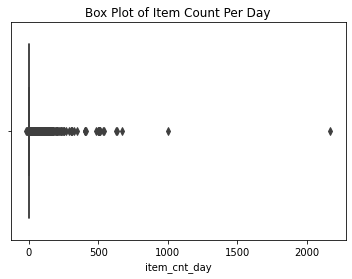

In [21]:
# It looks like there may be some outliers
sns.boxplot(x=dfSales['item_cnt_day'])
plt.title("Box Plot of Item Count Per Day");

In [ ]:
# Before transforming the data, I want to grab some histograms by store and item
# This will not take the daily count into consideration 
# The mean is close to 1 so a simple histogram will be a decent visualization to get started
# As we can see from the boxplot three are some outliers and they will be treated the same in the histogram as a single sale


Text(0.5, 1.0, 'Histogram of Records for item_ids')

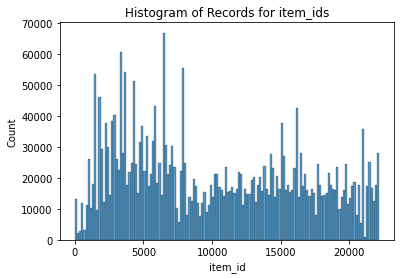

In [25]:
sns.histplot(dfSales['item_id'])
plt.title("Histogram of Records for item_ids")

Text(0.5, 1.0, 'Histogram of Records for shop_ids')

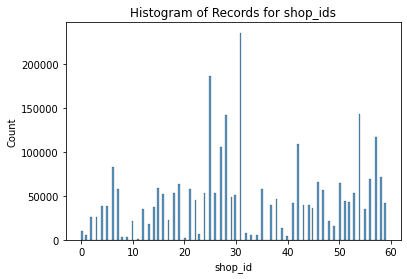

In [26]:
sns.histplot(dfSales['shop_id'])
plt.title("Histogram of Records for shop_ids")

In [36]:
# There are clearly shops with fewer sales, I am curious if the ones with fewer sales have bigger numbers per sale
# Lets group by shop ID
dfShopItems = dfSales.groupby(by='shop_id').sum()['item_cnt_day'].reset_index()
dfShopItems.head()

,shop_id,item_cnt_day
0,0,11705.0
1,1,6311.0
2,2,30620.0
3,3,28355.0
4,4,43942.0


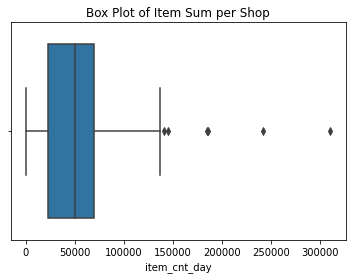

In [37]:
sns.boxplot(x=dfShopItems['item_cnt_day'])
plt.title("Box Plot of Item Sum per Shop");
# Nice outliers

In [41]:
dfShopItems.describe()

,shop_id,item_cnt_day
count,60.000000,60.000000
mean,29.500000,60803.433333
std,17.464249,57992.901750
min,0.000000,330.000000
25%,14.750000,23333.000000
50%,29.500000,50176.000000
75%,44.250000,69562.250000
max,59.000000,310777.000000


In [45]:
dfShopItems[dfShopItems['item_cnt_day'] > 140000]

,shop_id,item_cnt_day
25,25,241920.0
28,28,184557.0
31,31,310777.0
42,42,144934.0
54,54,185790.0
57,57,141107.0


In [47]:
# I want to take a deeper look at shop 31
dfSales[dfSales['shop_id'] == 31].describe()
# It looks like shop 31 just has high volume
# The max item cnt per day is not huge
# The mean and std is about the same as the general population
# I did not do a t-test to verify that distribution was the same

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,235636.000000,235636.0,235636.000000,235636.000000,235636.000000
mean,14.935341,31.0,11093.120033,724.691619,1.318886
std,9.544102,0.0,6176.734564,1383.986135,2.199277
min,0.000000,31.0,26.000000,0.100000,-2.000000
25%,7.000000,31.0,5612.000000,199.000000,1.000000
50%,14.000000,31.0,11268.000000,374.250000,1.000000
75%,23.000000,31.0,16205.000000,790.000000,1.000000
max,33.000000,31.0,22167.000000,35991.000000,288.000000


In [53]:
# I will probably toss many of these high quanity items
# but lets investigate a bit more
display(dfSales[dfSales['item_cnt_day'] > 500])
item_list = set(dfSales[dfSales['item_cnt_day'] > 500]['item_id'])

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1573253,22.04.2014,15,27,8057,1200.000000,502.0
1708207,28.06.2014,17,25,20949,5.000000,501.0
2048518,02.10.2014,21,12,9242,1500.000000,512.0
2067669,09.10.2014,21,55,19437,899.000000,508.0
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2608040,14.04.2015,27,12,3731,1904.548077,624.0
2626181,19.05.2015,28,12,11373,155.192950,539.0
2851073,29.09.2015,32,55,9249,1500.000000,533.0
2851091,30.09.2015,32,55,9249,1702.825746,637.0
2864235,30.09.2015,32,12,9248,1692.526158,669.0


In [49]:
# I previously said I didn't want to look at item descriptions, 
# but I want to see what is going on with come off these high cost and high volume items
dfItemDescription = pd.read_csv("../input/future-sales/items.csv")

In [52]:
dfItemDescription[dfItemDescription['item_id'].isin(item_list)]

,item_name,item_id,item_category_id
3731,"Grand Theft Auto V [PC, русские субтитры]",3731,30
8057,iTunes 1500 руб.,8057,32
9242,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",9242,8
9248,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",9248,80
9249,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",9249,8
11373,Доставка до пункта выдачи (Boxberry),11373,9
19437,"Средиземье: Тени Мордора [PC, Цифровая версия]",19437,31
20949,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71


* In the above output, we can see some interesting trends such as GameWorld tickets being sold only on 2 days
* Some of the other items may be due to game releases
* For example Middle-earth: Shadows of Mordo was released in Russia on 3 Oct 2014. The spike for that product is on 9 Oct 2014
* The purpose of this exercise is to predict trends
* Major game releases happen but I would like to remove them for this analysis since predicting those trends is out of scope of this analysis

In [54]:
# Look for other ticket sales
dfItemDescription[dfItemDescription['item_name'].str.contains("Билет")]

,item_name,item_id,item_category_id
9240,"Билет ""День Бухгалтерии""",9240,73
9241,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",9241,8
9242,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",9242,8
9243,"Билет ""ИгроМир 2014"" - семейный до 4-х человек...",9243,8
9244,"Билет ""ИгроМир 2015"" - 2 октября 2015 (сайт) [...",9244,80
9245,"Билет ""ИгроМир 2015"" - 2 октября 2015 (сайт) У...",9245,8
9246,"Билет ""ИгроМир 2015"" - 2 октября 2015 [Цифрова...",9246,80
9247,"Билет ""ИгроМир 2015"" - 2 октября 2015 УПР [Циф...",9247,8
9248,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",9248,80
9249,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",9249,8


In [61]:
# Drop ticket sales 
# These seem to be in October and they may skew the Novemeber estimate to be too hight
ticket_ids = set(dfItemDescription[dfItemDescription['item_name'].str.contains("Билет")]['item_id'])
dfSales.drop(dfSales[dfSales['item_id'].isin(ticket_ids)].index,inplace=True)
dfSales.drop(dfSales[dfSales['item_id'].isin(item_list)].index,inplace=True)

### Data Transformation
* We completed initial cleaning
* Now we will transform the data to a frame that contains shop id and item id and sum for each month


In [116]:
# I may be able to simplify this using a join
# Drop price
try:
    dfSales.drop(['item_price'],axis=1,inplace=True)
except:
    print("I probably already did this")
dfShopItems = dfSales.groupby(by=['date_block_num', 'shop_id', 'item_id']).sum().reset_index()
dfShopItems

I probably already did this


,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1606703,33,59,22087,6.0
1606704,33,59,22088,2.0
1606705,33,59,22091,1.0
1606706,33,59,22100,1.0


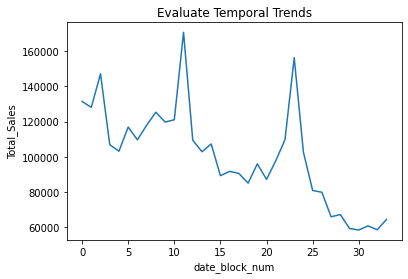

In [128]:
### Visualization of general sales trends
dfMonths = dfShopItems.groupby(by=['date_block_num'] ,as_index=False).sum()
dfMonths.rename(columns={'item_cnt_day':'Total_Sales'},inplace=True)
sns.lineplot(y=dfMonths['Total_Sales'],x=dfMonths['date_block_num'])
plt.title("Evaluate Temporal Trends");

In [130]:
# We see a spike at month 11 and 23. What are they
dfSales[dfSales['date_block_num'] == 11].head(1)

,date,date_block_num,shop_id,item_id,item_cnt_day
1124316,04.12.2013,11,25,17769,1.0


In [131]:
dfSales[dfSales['date_block_num'] == 23].head(1)

,date,date_block_num,shop_id,item_id,item_cnt_day
2192637,24.12.2014,23,42,17279,1.0


In [132]:
## Not a surprise that it is December

In [133]:
# Now remove dfMonths to save memory
dfMonths = None 

In [93]:
# I want to fill in the holes, so I am making a data frame with crossproduct of date_block shop id and item_id
# Then I will it with dfShopItems and fills the NaNs with 0
dfTemp1 = pd.DataFrame(data=dfShopItems['date_block_num'].unique(),columns=["date_block_num"])
dfTemp2 = pd.DataFrame(data=dfShopItems['shop_id'].unique(),columns=["shop_id"])
dfTemp3 = pd.DataFrame(data=dfShopItems['item_id'].unique(),columns=["item_id"])
dfTemp4 = dfTemp1.merge(dfTemp2,how='cross')
dfShopItemsFull = dfTemp4.merge(dfTemp3,how='cross')

In [94]:
# Clear out my temp frames so I can save memory
dfTemp1 = None
dfTemp2 = None
dfTemp3 = None
dfTemp4 = None

In [97]:
dfShopItemsFull['item_cnt_month'] = 0  
dfShopItemsFull.tail()

,date_block_num,shop_id,item_id,item_cnt_month
44443435,33,36,12733,0
44443436,33,36,13092,0
44443437,33,36,16797,0
44443438,33,36,18060,0
44443439,33,36,15925,0


In [101]:
# Spot checking to make sure it is expanding as expected
dfShopItemsFull[dfShopItemsFull['item_id'] == 15925]

,date_block_num,shop_id,item_id,item_cnt_month
21785,0,0,15925,0
43571,0,1,15925,0
65357,0,2,15925,0
87143,0,3,15925,0
108929,0,4,15925,0
...,...,...,...,...
44356295,33,34,15925,0
44378081,33,33,15925,0
44399867,33,20,15925,0
44421653,33,11,15925,0


In [103]:
# Align the indexes
dfShopItemsFull = dfShopItemsFull.set_index(['date_block_num','shop_id','item_id'])
dfShopItems = dfShopItems.set_index(['date_block_num','shop_id','item_id'])

In [105]:
dfShopItemsFull['item_cnt_month'] = dfShopItems['item_cnt_day'] 

In [106]:
dfShopItemsFull 
# We can see just in this view that there are NaNs

item_cnt_month
date_block_num shop_id item_id                
0              0       32                  6.0
                       33                  3.0
                       35                  1.0
                       43                  1.0
                       51                  2.0
...                                        ...
33             36      12733               NaN
                       13092               NaN
                       16797               NaN
                       18060               NaN
                       15925               NaN

[44443440 rows x 1 columns]

In [110]:
dfShopItemsFull.fillna(0,inplace=True) # This filled the holes 
# Change the index back so it is easier to deal with
# I am also going to remove the initial dataframe to save memory
dfShopItemsFull.reset_index(inplace=True)
dfShopItems = None

In [111]:
# Save off data frame so I can start a new notebook with data in this format
dfShopItemsFull.to_csv("dfShopItemsFull.csv",index=False)

## This concludes the intial EDA
##### I will attempt to append the other notebooks in a single PDF
* During the EDA process, I looked at the structure of the data 
* I dropped some data that were outliers
* I reformatted the data into a matrix with approximately 44 million records
* This allowed me to see every combination of shop, item, and month in the training data
* During the testing phase I discovered that there are items in the test data that are not in the training data at all
* This made me realize the importance of the item_category and item CSV files
* These files have categories of items such as book, video, music, game, ticket
* The existing category on their own is not enough
* We also need to create additional categories using natural language processing
* The data is in Russian, but we don't need to speak Russian to use many NLP processes
   * We can use a Russian stop words dictionary and then general statistical methods
